在2014年的ImageNet图像识别挑战赛中，一个名叫GoogLeNet的网络结构大放异彩 [1]。它虽然在名字上向LeNet致敬，但在网络结构上已经很难看到LeNet的影子。GoogLeNet吸收了NiN中网络串联网络的思想，并在此基础上做了很大改进。在随后的几年里，研究人员对GoogLeNet进行了数次改进，本节将介绍这个模型系列的第一个版本。

# Inception 块
GoogLeNet中的基础卷积块叫作`Inception`块，得名于同名电影《盗梦空间》（Inception）。与上一节介绍的NiN块相比，这个基础块在结构上更加复杂，如下图所示。
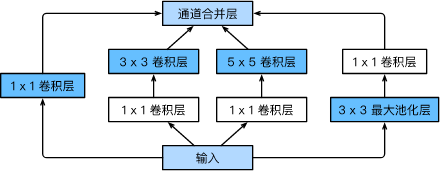
`Inception`块里有4条并行的线路。前3条线路使用窗口大小分别是1×1、3×3和5×5的卷积层来抽取不同空间尺寸下的信息，其中中间2个线路会对输入先做1×1卷积来减少输入通道数，以降低模型复杂度。第四条线路则使用3×3最大池化层，后接1×1卷积层来改变通道数。4条线路都使用了合适的填充来使输入与输出的高和宽一致。最后我们将每条线路的输出在通道维上连结，并输入接下来的层中去。

`Inception`块中可以自定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。

In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("../深度学习基础/") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Inception(nn.Module):
    # c1 —— c4 为每条线路里的层的输出通道数
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # 线路1，单 1 x 1 卷积层
        self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)
    
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

# GoogLeNet模型
GoogLeNet跟VGG一样，在主体卷积部分中使用5个模块（block），每个模块之间使用步幅为2的3×3最大池化层来减小输出高宽。第一模块使用一个64通道的7×7卷积层。

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第二模块使用2个卷积层：首先是64通道的1×1卷积层，然后是将通道增大3倍的3×3卷积层。它对应`Inception`块中的第二条线路。

In [4]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第三模块串联2个完整的`Inception`块。第一个`Inception`块的输出通道数为64+128+32+32=256，其中4条线路的输出通道数比例为64:128:32:32=2:4:1:1。其中第二、第三条线路先分别将输入通道数减小至96/192=1/2和16/192=1/12后，再接上第二层卷积层。第二个`Inception`块输出通道数增至128+192+96+64=480，每条线路的输出通道数之比为128:192:96:64=4:6:3:2。其中第二、第三条线路先分别将输入通道数减小至128/256=1/2和32/256=1/8。

In [5]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第四模块更加复杂。它串联了5个`Inception`块，其输出通道数分别是192+208+48+64=512、160+224+64+64=512、128+256+64+64=512、112+288+64+64=528和256+320+128+128=832。这些线路的通道数分配和第三模块中的类似，首先含3×3卷积层的第二条线路输出最多通道，其次是仅含1×1卷积层的第一条线路，之后是含5×5卷积层的第三条线路和含3×3最大池化层的第四条线路。其中第二、第三条线路都会先按比例减小通道数。这些比例在各个`Inception`块中都略有不同。

In [6]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第五模块有输出通道数为256+320+128+128=832和384+384+128+128=1024的两个`Inception`块。其中每条线路的通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均池化层来将每个通道的高和宽变成1。最后我们将输出变成二维数组后接上一个输出个数为标签类别数的全连接层。

In [7]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    d2l.GlobalAvgPool2d()
)

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。本节里我们将输入的高和宽从224降到96来简化计算。下面演示各个模块之间的输出的形状变化。

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,d2l.FlattenLayer(), nn.Linear(1024, 10))
X = torch.rand(1, 1, 96, 96)
for blk in net.children():
    X = blk(X)
    print('output shape:', X.shape)

output shape: torch.Size([1, 64, 24, 24])
output shape: torch.Size([1, 192, 12, 12])
output shape: torch.Size([1, 480, 6, 6])
output shape: torch.Size([1, 832, 3, 3])
output shape: torch.Size([1, 1024, 1, 1])
output shape: torch.Size([1, 1024])
output shape: torch.Size([1, 10])


# 获取数据和训练模型
我们使用高和宽均为96像素的图像来训练GoogLeNet模型。训练使用的图像依然来自Fashion-MNIST数据集。

In [ ]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

# 小结
+ `Inception`块相当于一个有4条线路的子网络。它通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并使用1×1卷积层减少通道数从而降低模型复杂度。
+ GoogLeNet将多个设计精细的`Inception`块和其他层串联起来。其中`Inception`块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
+ GoogLeNet和它的后继者们一度是ImageNet上最高效的模型之一：在类似的测试精度下，它们的计算复杂度往往更低。